## Przykład 1— Filtracja liniowa (konwolucja) + mean + Sobel


Filtracja liniowa polega na obliczeniu liniowej kombinacji pikseli w oknie filtru, czyli na wykonaniu konwolucji obrazu z maską.

Filtry liniowe to takie, które spełniają zasadę superpozycji - Oznacza to, że działanie filtru jest „proporcjonalne” i „dodawalne”. Matematycznie filtr liniowy to konwolucja obrazu z maską (jądrem filtru).

Cechy filtrów liniowych

* ich działanie można zapisać jako splot (konwolucję) obrazu z maską,
* są przewidywalne i stabilne,
* nie zmieniają relacji między wartościami w sposób warunkowy – każdy piksel jest traktowany identycznie.

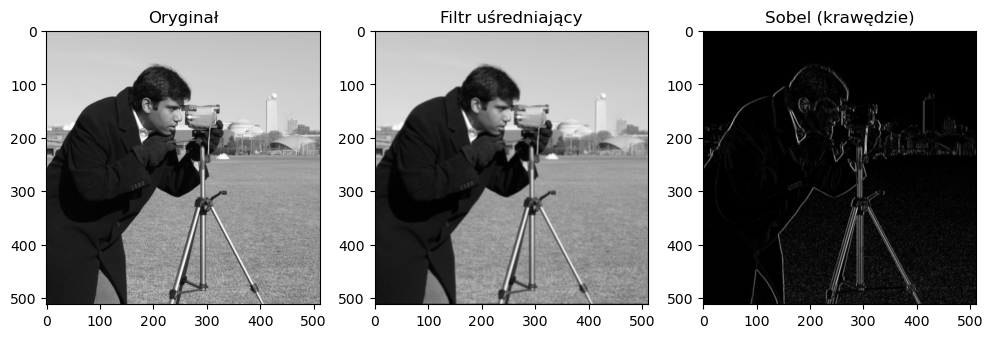

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color

# implementacja konwolucji

def conv(img, kernel):
    img = img.astype(float)
    k_h, k_w = kernel.shape
    pad_h, pad_w = k_h // 2, k_w // 2

    # padding
    padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')

    out = np.zeros_like(img)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded[i:i+k_h, j:j+k_w]
            out[i, j] = np.sum(region * kernel)

    return out

# Obraz testowy
img = data.camera()

# Mean filter 3×3
mean_kernel = np.ones((3, 3)) / 9

# Sobel – poziomy
sobel_kernel = np.array([
    [-1, 0,  1],
    [-2, 0,  2],
    [-1, 0,  1]
])

# Filtracje
smooth = conv(img, mean_kernel)
edges = np.abs(conv(img, sobel_kernel))

# Wyświetlenie
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1); plt.imshow(img, cmap='gray'); plt.title("Oryginał")
plt.subplot(1, 3, 2); plt.imshow(smooth, cmap='gray'); plt.title("Filtr uśredniający")
plt.subplot(1, 3, 3); plt.imshow(edges, cmap='gray'); plt.title("Sobel (krawędzie)")
plt.show()

## Przykład 2 — Filtracja nieliniowa: medianowa vs mean

Filtry nieliniowe nie spełniają zasady superpozycji — ich wynik zależy od tego, jakie wartości znajdują się w masce.
Zamiast konwolucji stosują operacje oparte na rankingu, logice, morfologii lub adaptacji.
Filtr medianowy:

* wybiera wartość środkową z uporządkowanego zbioru
* świetnie usuwa szum impulsowy („salt & pepper”)
* zachowuje krawędzie, których mean filter nie zachowuje

Filtr mean (uśredniający):

* rozmywa obraz
* usuwa szum, ale niszczy szczegóły


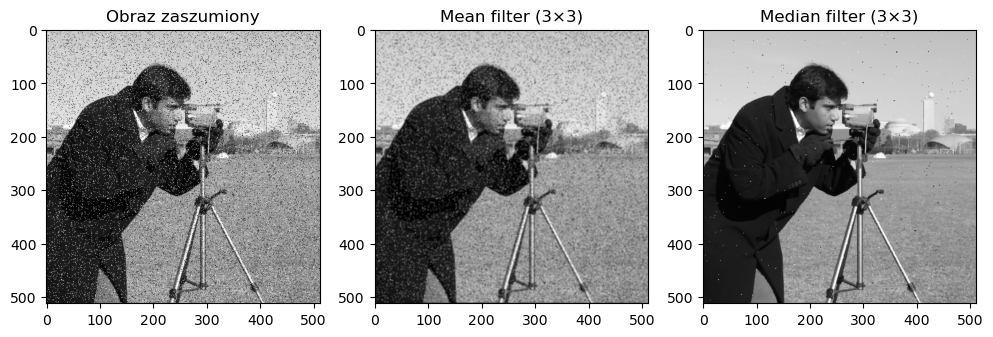

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color
from skimage.util import random_noise
from skimage.filters import median
from skimage.morphology import disk, dilation, erosion

# Obraz
img = data.camera()

# Dodanie szumu impulsowego
noisy = random_noise(img, mode='s&p', amount=0.1)

# Mean filter – wykorzystamy konwolucję z zadania 1
mean_kernel = np.ones((3,3)) / 9
def my_conv(img, kernel):
    img = img.astype(float)
    k_h, k_w = kernel.shape
    pad_h, pad_w = k_h // 2, k_w // 2
    padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
    out = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded[i:i+k_h, j:j+k_w]
            out[i, j] = np.sum(region * kernel)
    return out

mean_filtered = my_conv(noisy, mean_kernel)

# Median filter (3×3)
median_filtered = median(noisy, disk(1))

# Wyświetlenie
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1); plt.imshow(noisy, cmap='gray'); plt.title("Obraz zaszumiony")
plt.subplot(1, 3, 2); plt.imshow(mean_filtered, cmap='gray'); plt.title("Mean filter (3×3)")
plt.subplot(1, 3, 3); plt.imshow(median_filtered, cmap='gray'); plt.title("Median filter (3×3)")
plt.show()

## Przykład 3 — Detekcja krawędzi LoG + Zero Crossing


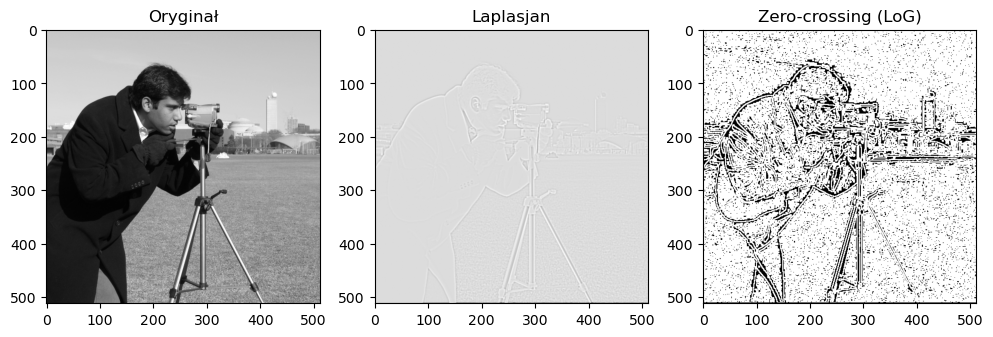

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.filters import gaussian

# Laplacian kernel (8-sąsiedztwa)
laplacian_kernel = np.array([
    [1,  1, 1],
    [1, -8, 1],
    [1,  1, 1]
])

# Konwolucja – ta sama z poprzednich zadań
def conv(img, kernel):
    k_h, k_w = kernel.shape
    pad_h, pad_w = k_h//2, k_w//2
    padded = np.pad(img, ((pad_h,pad_h),(pad_w,pad_w)), mode='constant')
    out = np.zeros_like(img, dtype=float)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded[i:i+k_h, j:j+k_w]
            out[i,j] = np.sum(region * kernel)
    return out

# 1. Obraz
img = data.camera().astype(float)

# 2. Wygładzanie Gaussowskie
blur = gaussian(img, sigma=1)

# 3. Laplasjan
lap = conv(blur, laplacian_kernel)

# 4. Wykrywanie przejść przez zero
zero_cross = np.zeros_like(lap)

for i in range(1, lap.shape[0]-1):
    for j in range(1, lap.shape[1]-1):
        neg = lap[i-1:i+2, j-1:j+2] < 0
        pos = lap[i-1:i+2, j-1:j+2] > 0

        if np.any(neg) and np.any(pos):
            zero_cross[i,j] = 1

# Wyświetlenie
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1); plt.imshow(img, cmap='gray'); plt.title("Oryginał")
plt.subplot(1, 3, 2); plt.imshow(lap, cmap='gray'); plt.title("Laplasjan")
plt.subplot(1, 3, 3); plt.imshow(zero_cross, cmap='gray'); plt.title("Zero-crossing (LoG)")
plt.show()

## Zadanie 1. Konwolucja + filtr wyostrzający (sharpen) + Prewitt

Wykorzystując przykład 1, wykonaj poniższe polecenia:


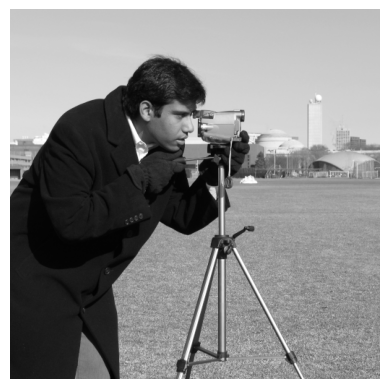

In [88]:
img = data.camera()

plt.axis("off")
plt.imshow(img, cmap="gray")

1. Użyj kod funkcji konwolucji, który został wcześniej przygotowany (conv() lub my_convolution()).

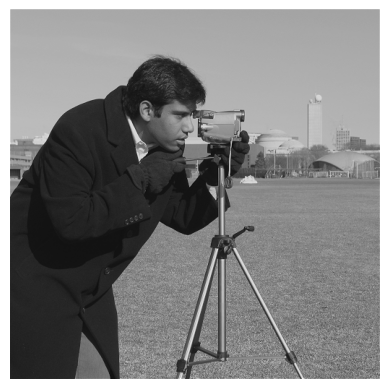

In [89]:
conved = conv(img, np.array([[0,-2,0],[-2,20,-2],[0,-2,0]]))

plt.axis("off")
plt.imshow(conved, cmap="gray")

2. Zastosuj dwa różne filtry:
* Filtr wyostrzający (sharpening kernel) — samodzielnie wybierz i wpisz maskę filtru, np. jedną z klasycznych masek wyostrzających 3×3.
* Detektor krawędzi Prewitta — wstaw maskę poziomą lub pionową (lub obie), zamiast poprzednio używanego operatora Sobela.


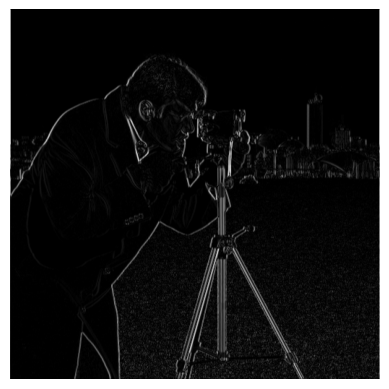

In [90]:
edges = np.abs(conv(img, sobel_kernel))


plt.axis("off")
plt.imshow(edges, cmap="gray")

3. Wyświetl trzy obrazy:
- oryginalny obraz,
- obraz po filtrze wyostrzającym,
- obraz z wykrytymi krawędziami Prewitta.

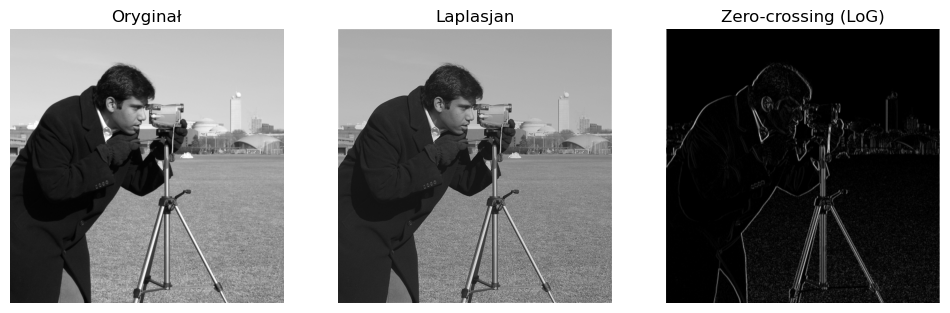

In [91]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1); plt.imshow(img, cmap='gray'); plt.title("Oryginał"); plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(conved, cmap='gray'); plt.title("Laplasjan"); plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(edges, cmap='gray'); plt.title("Zero-crossing (LoG)"); plt.axis("off")
plt.show()

## Zadanie 2. Porównanie filtrów medianowego, minimum i maksimum (filtracja nieliniowa)

W tym zadaniu przeanalizujesz działanie trzech różnych filtrów nieliniowych na obrazie zaszumionym szumem impulsowym („salt & pepper”). Celem jest zrozumienie, jak poszczególne filtry zachowują się wobec jasnych i ciemnych zakłóceń oraz jak wpływają na strukturę obrazu.

Wykorzystując kod z przykładu 2:

1. Wczytaj obraz w skali szarości (np. „camera” z biblioteki skimage.data).

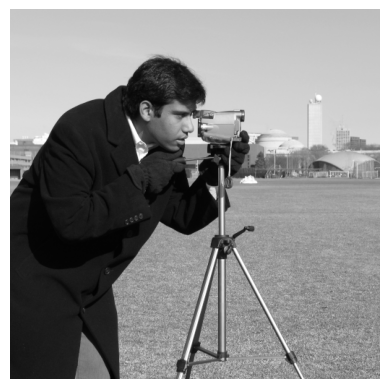

In [92]:
img = data.camera()

plt.axis("off")
plt.imshow(img, cmap="gray")

2. Dodaj do obrazu szum impulsowy („salt & pepper”).
Ustal poziom szumu tak, by artefakty były dobrze widoczne (np. amount=0.1).

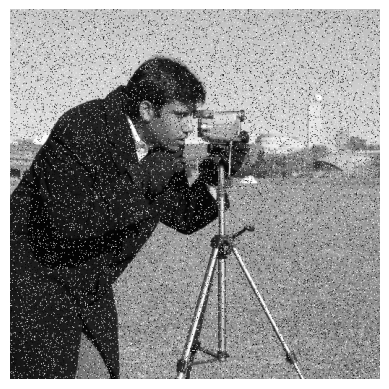

In [93]:
noisy = random_noise(img, mode='s&p', amount=0.1)

plt.axis("off")
plt.imshow(noisy, cmap="gray")

3. Zastosuj trzy filtry nieliniowe:
* Filtr medianowy (3×3) — usuwa zarówno jasne, jak i ciemne zakłócenia, jednocześnie dobrze zachowując krawędzie.
* Filtr minimum (erosion) — usuwa głównie jasne punkty („salt”), a pozostawia ciemniejsze elementy.
* Filtr maksimum (dilation) — usuwa głównie ciemne punkty („pepper”), a wzmacnia jaśniejsze elementy.

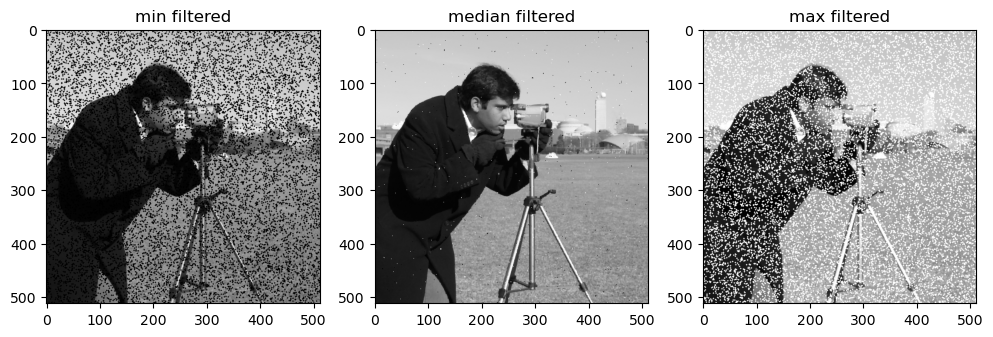

In [94]:
median_filtered = median(noisy, disk(1))
erosion_filtered = erosion(noisy, disk(1))
dilation_filtered = dilation(noisy, disk(1))

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1); plt.imshow(erosion_filtered, cmap='gray'); plt.title("min filtered")
plt.subplot(1, 3, 2); plt.imshow(median_filtered, cmap='gray'); plt.title("median filtered")
plt.subplot(1, 3, 3); plt.imshow(dilation_filtered, cmap='gray'); plt.title("max filtered")
plt.show()

4. Porównaj wyniki filtracji, wyświetlając cztery obrazy:
* obraz zaszumiony,
* wynik filtru medianowego,
* wynik filtru minimum,
* wynik filtru maksimum.

## Zadanie 3. Detekcja krawędzi metodą Zero-Crossing z inną maską Laplasjanu i większym wygładzeniem


1. Wczytaj obraz w skali szarości (np. „camera” z skimage.data).

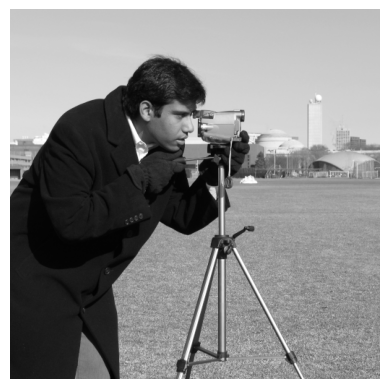

In [95]:
img = data.camera()

plt.axis("off")
plt.imshow(img, cmap="gray")

2. Wygładź obraz filtrem Gaussa, ustawiając: odchylenie standardowe sigma = 2.0
(większa wartość powinna wyraźnie mocniej wygładzić szczegóły i zaszumione fragmenty).

Zastosuj inną maskę laplasjanu niż wcześniej — użyj wersji o 4-sąsiedztwie, czyli:

[0  1  0] \
[1 -4  1] \
[0  1  0]

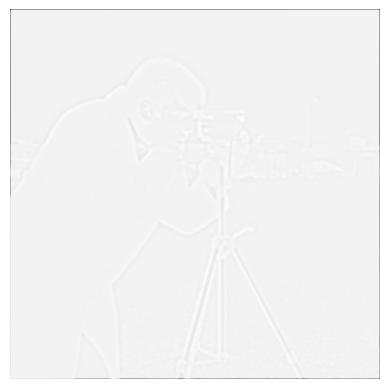

In [96]:
blur = gaussian(img, sigma=2.0)
kernel = np.array([[0,1,0],[1,-4,1],[0,1,0]])
lap = conv(blur, kernel)
plt.axis("off")
plt.imshow(lap, cmap="gray")

3. Przeprowadź konwolucję wygładzonego obrazu z tą maską laplasjanu.

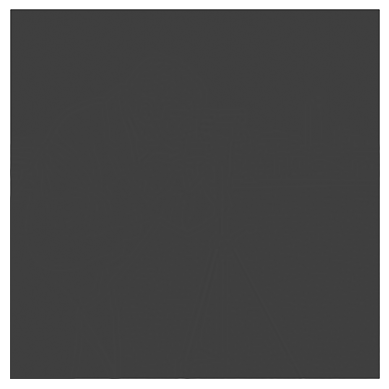

In [97]:
conved = conv(lap, kernel)
plt.axis("off")
plt.imshow(conved, cmap="gray")

4. Wykryj przejścia przez zero (zero-crossing)

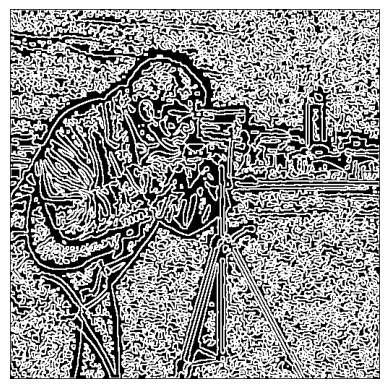

In [98]:
zero_cross = np.zeros_like(lap)

for i in range(1, lap.shape[0]-1):
    for j in range(1, lap.shape[1]-1):
        neg = lap[i-1:i+2, j-1:j+2] < 0
        pos = lap[i-1:i+2, j-1:j+2] > 0

        if np.any(neg) and np.any(pos):
            zero_cross[i,j] = 1

plt.axis("off")
plt.imshow(zero_cross, cmap="gray")


Wyświetl trzy obrazy:
* oryginalny obraz,
* wynik filtracji laplasjanem,
* wynik detekcji zero-crossing (obraz binarny).

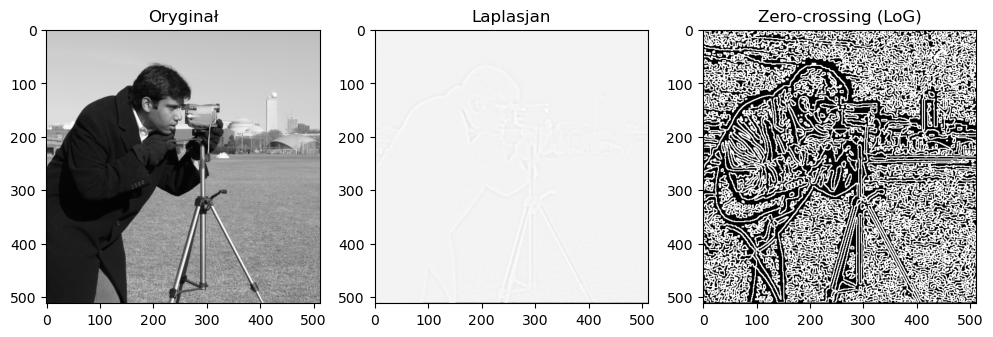

In [99]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1); plt.imshow(img, cmap='gray'); plt.title("Oryginał")
plt.subplot(1, 3, 2); plt.imshow(lap, cmap='gray'); plt.title("Laplasjan")
plt.subplot(1, 3, 3); plt.imshow(zero_cross, cmap='gray'); plt.title("Zero-crossing (LoG)")
plt.show()